In [15]:
# Import necessary libraries
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import export_text

# Win Prediction at half time - Decision Tree

## Import Dataset

In [16]:
local_path='dataset/soccer18-19.csv'
auto='auto'
df='df_half.csv'

In [17]:
# get current directory
path = os.getcwd()
print("Current Directory", path)
print()
 
# parent directory
parent = os.path.dirname(path)
print("Parent directory", parent)
print()

# dataset path
dataset_path=os.path.join(parent,auto,df)
print("Dataset path",dataset_path)
print()

# auto path
path_auto=os.path.join(parent,auto)
print("Dump path",path_auto)

Current Directory /home/baptiste/GDrive/learning/Python/polars_explo/project/football/notebook

Parent directory /home/baptiste/GDrive/learning/Python/polars_explo/project/football

Dataset path /home/baptiste/GDrive/learning/Python/polars_explo/project/football/auto/df_half.csv

Dump path /home/baptiste/GDrive/learning/Python/polars_explo/project/football/auto


In [18]:
df=pd.read_csv(dataset_path)

print("shape:", df.shape)

df.head(5)

shape: (760, 9)


,Div,Team,Oponent,Oponent_HTG,HTG,HTR,Referee,Venue,FTR
0,E0,Man United,Leicester,0,1,WIN,A Marriner,HOME,WIN
1,E0,Bournemouth,Cardiff,0,1,WIN,K Friend,HOME,WIN
2,E0,Fulham,Crystal Palace,1,0,LOSE,M Dean,HOME,LOSE
3,E0,Huddersfield,Chelsea,2,0,LOSE,C Kavanagh,HOME,LOSE
4,E0,Newcastle,Tottenham,2,1,LOSE,M Atkinson,HOME,LOSE


## Decision Tree

### Prepare Train Test Data & Encode

In [19]:
# Separate features (X) and target variable (y)
X = df.drop('FTR', axis=1)
y = df['FTR']

# Identify categorical columns (you might need to adjust this based on your dataset)
categorical_columns = X.select_dtypes(include=['object']).columns

# Create a ColumnTransformer to apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'
)

### Model Fitting & Result

In [20]:

# Create a pipeline with the preprocessing step and the Decision Tree Classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=3,
        criterion='gini',
        min_samples_leaf=4,
        min_samples_split=5
        ))
])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier on the training set
pipeline.fit(
    X_train, 
    y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)


In [21]:
# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6381578947368421


### Feature Importance

In [22]:
# Access feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns), 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the relevant features and their importances
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                      Feature  Importance
43               cat__HTR_WIN    0.618619
42              cat__HTR_LOSE    0.263611
64             remainder__HTG    0.035393
53       cat__Referee_L Mason    0.033882
63     remainder__Oponent_HTG    0.033261
..                        ...         ...
28       cat__Oponent_Everton    0.000000
29        cat__Oponent_Fulham    0.000000
30  cat__Oponent_Huddersfield    0.000000
31     cat__Oponent_Leicester    0.000000
32     cat__Oponent_Liverpool    0.000000

[65 rows x 2 columns]


### Tree Visualization

In [23]:
# Print the decision tree rules
tree_rules = export_text(pipeline.named_steps['classifier'], feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns))
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- cat__HTR_WIN <= 0.50
|   |--- cat__HTR_LOSE <= 0.50
|   |   |--- cat__Referee_L Mason <= 0.50
|   |   |   |--- class: LOSE
|   |   |--- cat__Referee_L Mason >  0.50
|   |   |   |--- class: DRAW
|   |--- cat__HTR_LOSE >  0.50
|   |   |--- remainder__Oponent_HTG <= 1.50
|   |   |   |--- class: LOSE
|   |   |--- remainder__Oponent_HTG >  1.50
|   |   |   |--- class: LOSE
|--- cat__HTR_WIN >  0.50
|   |--- remainder__HTG <= 1.50
|   |   |--- cat__Team_Newcastle <= 0.50
|   |   |   |--- class: WIN
|   |   |--- cat__Team_Newcastle >  0.50
|   |   |   |--- class: DRAW
|   |--- remainder__HTG >  1.50
|   |   |--- cat__Team_Bournemouth <= 0.50
|   |   |   |--- class: WIN
|   |   |--- cat__Team_Bournemouth >  0.50
|   |   |   |--- class: WIN



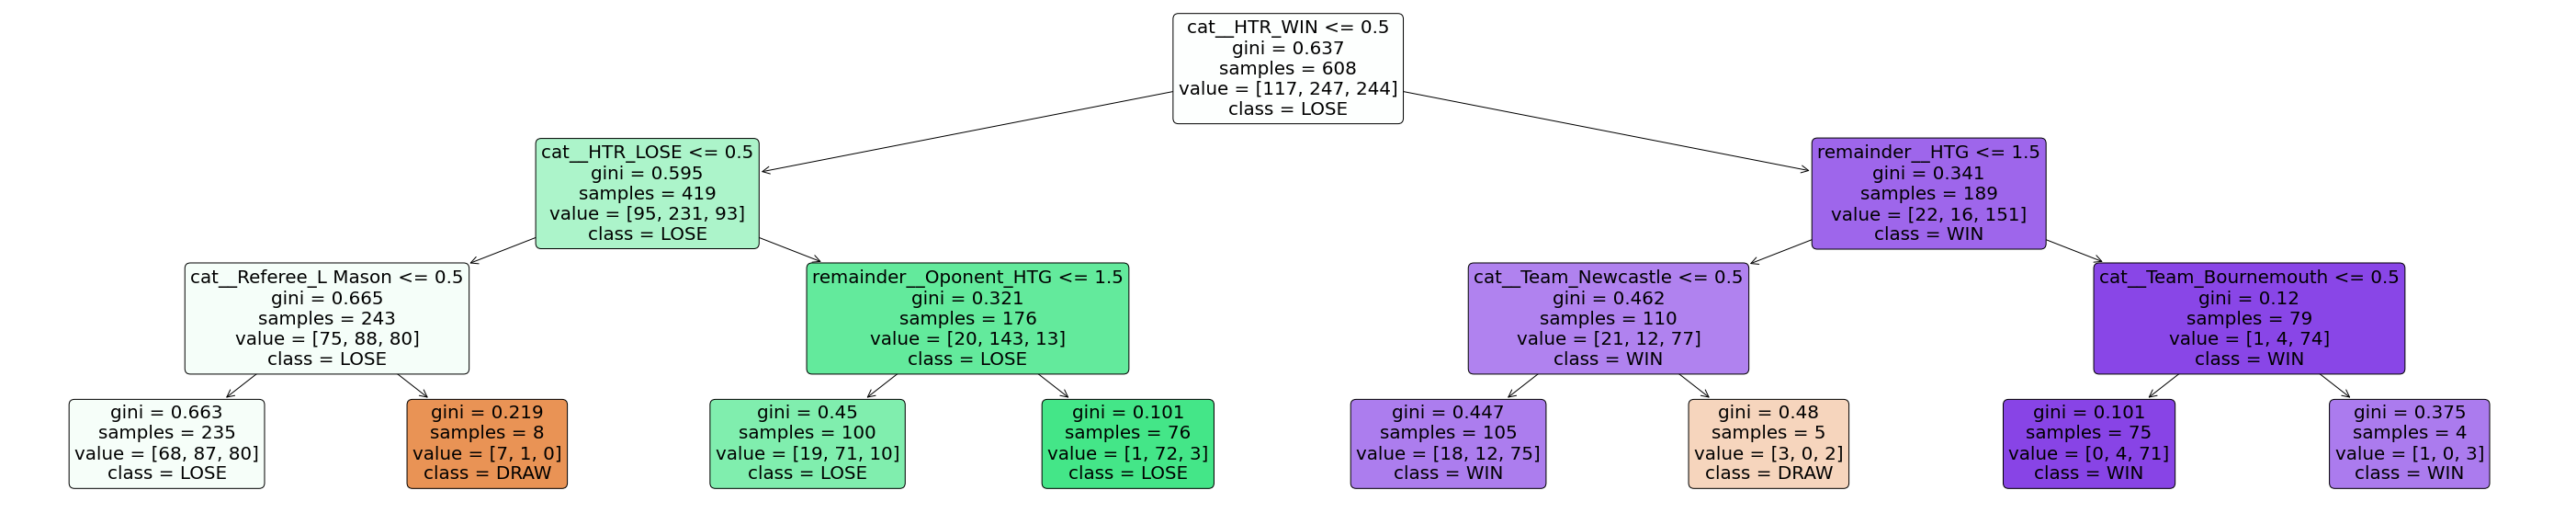

In [24]:
# Visualize the decision tree using plot_tree
plt.figure(figsize=(50, 10))
plot_tree(pipeline.named_steps['classifier'], feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns), class_names=[str(x) for x in pipeline.named_steps['classifier'].classes_], filled=True, rounded=True)
plt.show()

## Tuning Hyper Parameters

In [25]:
# Define the hyperparameters to tune
param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 2, 3, 4],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to search for the best combination of hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         Index(['Div', 'Team', 'Oponent', 'HTR', 'Referee', 'Venue'], dtype='object'))])),
                                       ('classifier',
                                        DecisionTreeClassifier(max_depth=3,
                                                               min_samples_leaf=4,
                                                               min_samples_split=5))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 2, 3, 4],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [26]:
# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best Hyperparameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Accuracy: 0.631578947368421


In [27]:
# Print the decision tree rules of the best model
best_model = grid_search.best_estimator_
tree_rules = export_text(best_model.named_steps['classifier'], feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns))
print("Decision Tree Rules:")
print(tree_rules)

Decision Tree Rules:
|--- cat__HTR_WIN <= 0.50
|   |--- cat__HTR_DRAW <= 0.50
|   |   |--- class: LOSE
|   |--- cat__HTR_DRAW >  0.50
|   |   |--- class: LOSE
|--- cat__HTR_WIN >  0.50
|   |--- remainder__HTG <= 1.50
|   |   |--- class: WIN
|   |--- remainder__HTG >  1.50
|   |   |--- class: WIN



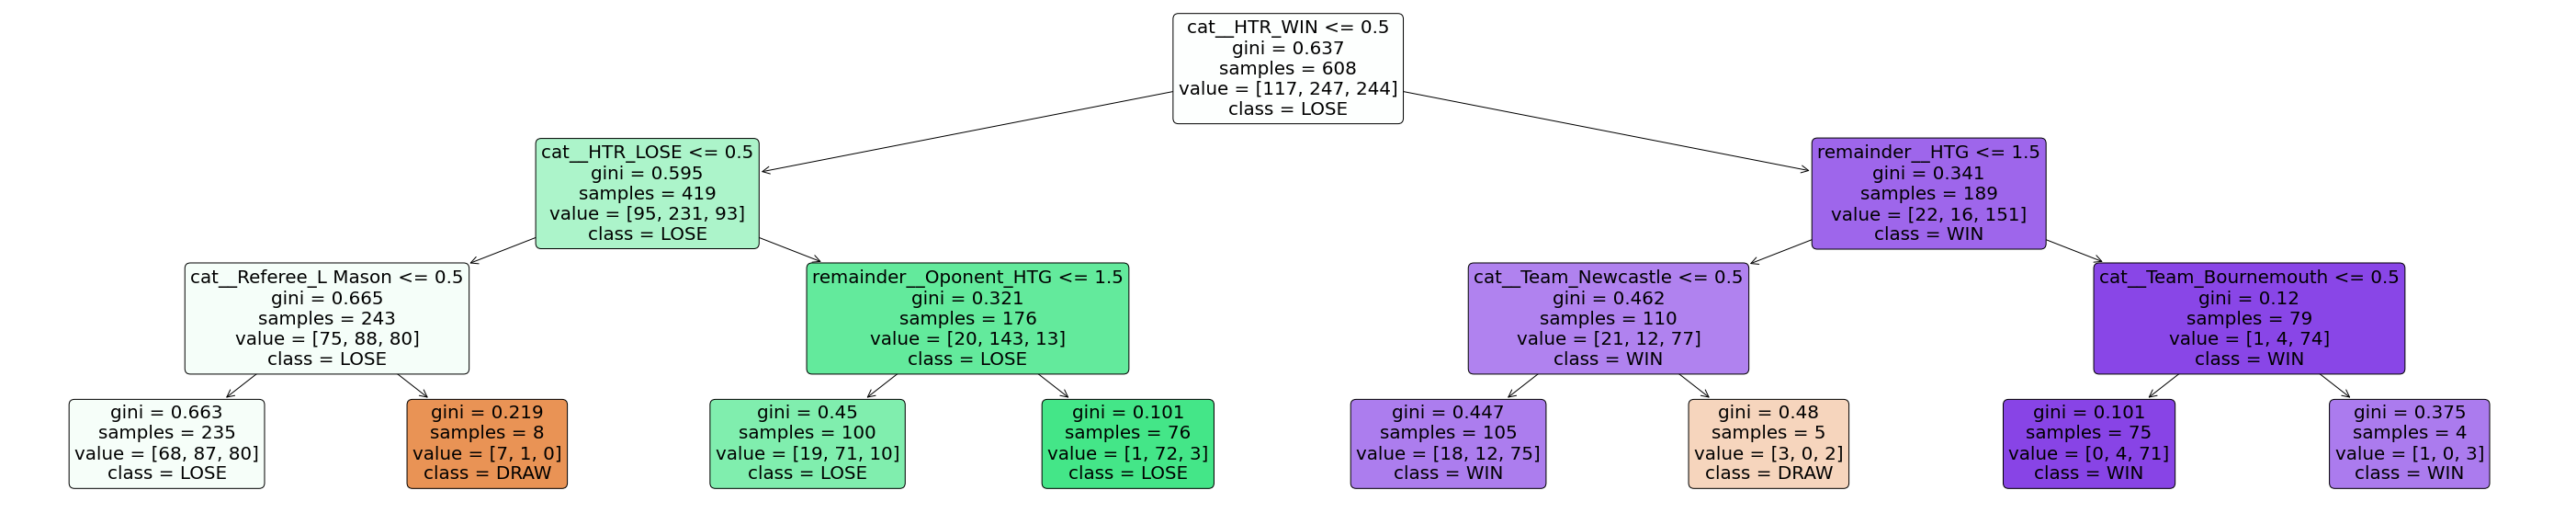

In [28]:
# Visualize the decision tree using plot_tree
plt.figure(figsize=(50, 10))
plot_tree(pipeline.named_steps['classifier'], feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X.columns), class_names=[str(x) for x in pipeline.named_steps['classifier'].classes_], filled=True, rounded=True)
plt.show()